### Transforming documents into a sparse matrix ###

In this activity, we will learn one way to transform documents from text to a sparse matrix that can be used for different data mining tasks.

In [1]:
import numpy as np
import scipy as sp
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# open docs file and read its lines
with open("data/qa/docs.txt", "r") as fh:
    lines = fh.readlines()  

How many documents do we have? Write some code to print the number of lines in docs.txt.

In [3]:
len(lines)

60

Create a list variable called `docs` that contains a list of lists, one for each document, s.t. the $i$th list is a list of all lower-cased words in the $i$th document. Print out the total number of words in the collection and the average number of words per document.

In [11]:
# transform docs into lists of words
docs = [[w.lower() for w in l.split() if len(w) > 0] for l in lines ]

The functions plotWf and plotDf below compute and plot the word frequency distribution (how many times each word is found in the collection) and document frequency distributions (how many documents each word is found in), respectively. Note how they are constructed. Then, execute the cell below to register the functions. In the following cell, execute the functions to plot the frequency distributions.

In [12]:
def plotWf(docs, plot=True, logscale=True):
    r"""Get collection-wide word frequencies and optionally plot them."""
    words = defaultdict(int)
    for d in docs:
        for w in d:
            words[w] += 1
    if plot is True:
        plt.plot(sorted(words.values(), reverse=True))
        plt.xlabel('word')
        plt.ylabel('frequency')
        if logscale is True:
            plt.yscale('log')
            plt.ylabel('log(frequency)')
        plt.title('Corpus-wide word frequency distribution')
        plt.show()
    return words

def plotDf(docs, plot=True, logscale=False):
    r"""Get collection-wide word frequencies and optionally plot them."""
    # document word frequency
    df = defaultdict(int)
    for d in docs:
        for w in set(d):
            df[w] += 1
    if plot is True:
        plt.plot(sorted(df.values(), reverse=True))
        plt.xlabel('word')
        plt.ylabel('frequency')
        if logscale is True:
            plt.yscale('log')
            plt.ylabel('log(frequency)')
        plt.title('Corpus-wide document-word frequency distribution')
        plt.show()
    return df

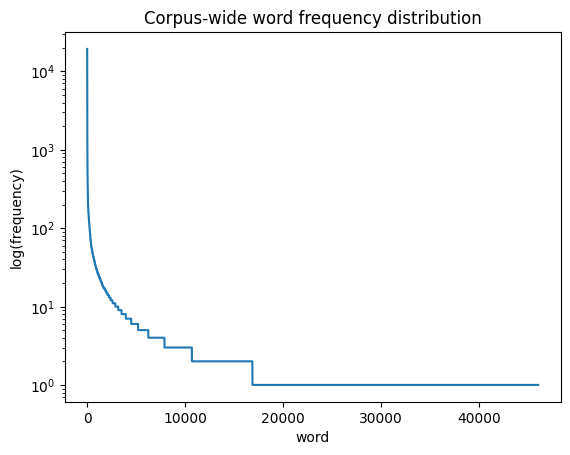

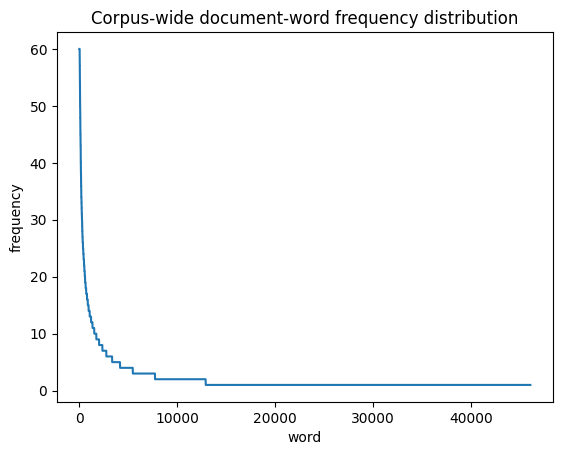

In [13]:
_ = plotWf(docs)
_ = plotDf(docs)

The `filterLen` function filters out words that may be too short based on the minlen parameter. Execute the code below to see the difference between a document with all words and a document with 3-letter and shorter words removed.

In [14]:
def filterLen(docs, minlen):
    r""" filter out terms that are too short. 
    docs is a list of lists, each inner list is a document represented as a list of words
    minlen is the minimum length of the word to keep
    """
    return [ [t for t in d if len(t) >= minlen ] for d in docs ]
docs1 = filterLen(docs, 4)
print(len(docs[0]), docs[0][:20])
print(len(docs1[0]), docs1[0][:20])

3813 ['octopus', 'the', 'octopus', 'is', 'a', 'cephalopod', 'of', 'the', 'order', 'octopoda.', 'octopuses', 'have', 'two', 'eyes', 'and', 'four', 'pairs', 'of', 'arms', 'and']
2555 ['octopus', 'octopus', 'cephalopod', 'order', 'octopoda.', 'octopuses', 'have', 'eyes', 'four', 'pairs', 'arms', 'like', 'other', 'cephalopods', 'bilaterally', 'symmetric.', 'octopus', 'hard', 'beak,', 'with']


Re-execute the `plotWf` and `plotDf` functions to see the difference after filering.

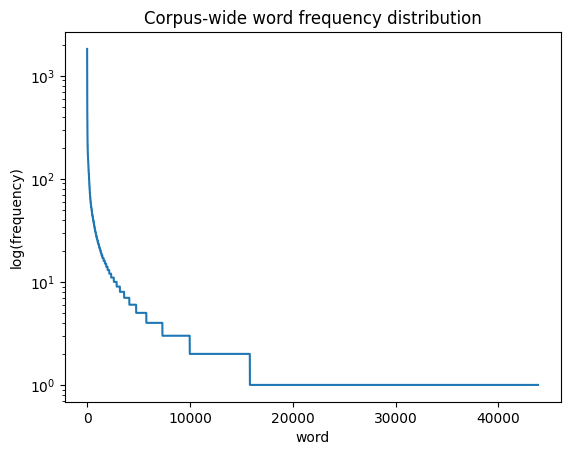

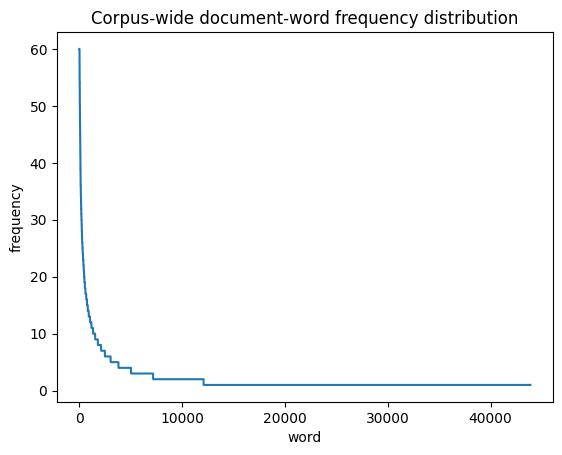

In [15]:
_ = plotWf(docs1)
_ = plotDf(docs1)

The `build_matrix` function will transform a collection represented as a list of lists of words into a sparse matrix, using the same technique we saw in class. The `csr_info` function will display some statistics about the sparse matrix. Study the functions and then run them for the two document collections, as follows:

> * mat = build_matrix(docs)
> * mat1 = build_matrix(docs1)

Finally, print out matrix stats for the two matrices:

> * csr_info(mat, "mat", non_empy=True)
> * csr_info(mat1, "mat1", non_empy=True)

Make sure you run the cell below first in order to register the functions.

In [18]:
from collections import Counter
from scipy.sparse import csr_matrix
def build_matrix(docs):
    r""" Build sparse matrix from a list of documents, 
    each of which is a list of word/terms in the document.  
    """
    nrows = len(docs)
    idx = {}
    tid = 0
    nnz = 0
    for d in docs:
        nnz += len(set(d))
        for w in d:
            if w not in idx:
                idx[w] = tid
                tid += 1
    ncols = len(idx)
        
    # set up memory
    ind = np.zeros(nnz, dtype=int)
    val = np.zeros(nnz, dtype=np.double)
    ptr = np.zeros(nrows+1, dtype=int)
    i = 0  # document ID / row counter
    n = 0  # non-zero counter
    # transfer values
    for d in docs:
        cnt = Counter(d)
        keys = list(k for k,_ in cnt.most_common())
        l = len(keys)
        for j,k in enumerate(keys):
            ind[j+n] = idx[k]
            val[j+n] = cnt[k]
        ptr[i+1] = ptr[i] + l
        n += l
        i += 1
            
    mat = csr_matrix((val, ind, ptr), shape=(nrows, ncols), dtype=np.double)
    mat.sort_indices()
    
    return mat


def csr_info(mat, name="", non_empy=False):
    r""" Print out info about this CSR matrix. If non_empy, 
    report number of non-empty rows and cols as well
    """
    if non_empy:
        print("%s [nrows %d (%d non-empty), ncols %d (%d non-empty), nnz %d]" % (
                name, mat.shape[0], 
                sum(1 if mat.indptr[i+1] > mat.indptr[i] else 0 
                for i in range(mat.shape[0])), 
                mat.shape[1], len(np.unique(mat.indices)), 
                len(mat.data)))
    else:
        print( "%s [nrows %d, ncols %d, nnz %d]" % (name, 
                mat.shape[0], mat.shape[1], len(mat.data)) )

In [19]:
mat = build_matrix(docs)
mat1 = build_matrix(docs1)
csr_info(mat)
csr_info(mat1)

 [nrows 60, ncols 46054, nnz 105026]
 [nrows 60, ncols 43864, nnz 96335]


To decrease the importance of popular words in similarity computations, we usually scale the matrix by the *Inverse Document Frequency* (IDF). Furthermore, normalizing the vectors helps us compute cosine similarity more efficiently. Run the cell below to scale the `mat` matrix and create a second version with normalized row vectors. Note how the scaling and normalization are done in `O(nnz)` time.

In [20]:
# scale matrix and normalize its rows
def csr_idf(mat, copy=False, **kargs):
    r""" Scale a CSR matrix by idf. 
    Returns scaling factors as dict. If copy is True, 
    returns scaled matrix and scaling factors.
    """
    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    # document frequency
    df = defaultdict(int)
    for i in ind:
        df[i] += 1
    # inverse document frequency
    for k,v in df.items():
        df[k] = np.log(nrows / float(v))  ## df turns to idf - reusing memory
    # scale by idf
    for i in range(0, nnz):
        val[i] *= df[ind[i]]
        
    return df if copy is False else mat

def csr_l2normalize(mat, copy=False, **kargs):
    r""" Normalize the rows of a CSR matrix by their L-2 norm. 
    If copy is True, returns a copy of the normalized matrix.
    """
    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    # normalize
    for i in range(nrows):
        rsum = 0.0    
        for j in range(ptr[i], ptr[i+1]):
            rsum += val[j]**2
        if rsum == 0.0:
            continue  # do not normalize empty rows
        rsum = 1.0/np.sqrt(rsum)
        for j in range(ptr[i], ptr[i+1]):
            val[j] *= rsum
            
    if copy is True:
        return mat
mat2 = csr_idf(mat1, copy=True)
mat3 = csr_l2normalize(mat2, copy=True)
print("mat1:", mat1[15,:20].todense(), "\n")
print("mat2:", mat2[15,:20].todense(), "\n")
print("mat3:", mat3[15,:20].todense())

mat1: [[ 0.  0.  0.  0.  0.  3.  0.  2.  0.  0.  1.  8.  0.  0.  0.  0.  0. 21.
   0.  0.]] 

mat2: [[0.         0.         0.         0.         0.         0.15387988
  0.         0.57536414 0.         0.         0.22314355 0.27121241
  0.         0.         0.         0.         0.         0.
  0.         0.        ]] 

mat3: [[0.         0.         0.         0.         0.         0.00044558
  0.         0.00166604 0.         0.         0.00064614 0.00078533
  0.         0.         0.         0.         0.         0.
  0.         0.        ]]


Cosine similarity is defined as below. Using the matrices `mat1` and `mat2`, compute the cosine similarity between the 2nd and 6th rows in the respective matrices, without using a distance/similarity function from some library. You may only use scipy/numpy vector or matrix operations.

In [21]:
%%latex
$$cos(\mathbf{a}, \mathbf{b}) = \frac{\langle \mathbf{a}, 
          \mathbf{b} \rangle}{||\mathbf{a}||\ ||\mathbf{b}||}$$

<IPython.core.display.Latex object>

In [22]:
from scipy.sparse.linalg import norm
i = 0  # one row
j = 1  # another row
# compare cosine similarity of rows from mat2 vs. mat3
dp2 = mat2[i].dot(mat2[j].T).todense().item()  # the dot-product between the sparse vectors in mat2
print("dot-product in mat2: ", dp2)
print("norms in mat2: ", norm(mat2[i]), norm(mat2[j]))
print("cosine in mat2: ", dp2 / ( norm(mat2[i]) * norm(mat2[j])))
dp3 = mat3[i].dot(mat3[j].T).todense().item()  # the dot-product between the sparse vectors in mat3
print("dot-product in mat3: ", dp3)
print("norms in mat3: ", norm(mat3[i]), norm(mat3[j]))
print("cosine in mat3: ", dp3 / ( norm(mat3[i]) * norm(mat3[j])))

dot-product in mat2:  4682.127590583695
norms in mat2:  426.4100736821362 616.0638559727511
cosine in mat2:  0.017823379668418682
dot-product in mat3:  0.017823379668418637
norms in mat3:  1.0000000000000087 0.9999999999999878
cosine in mat3:  0.0178233796684187


In [23]:

# compare cosine similarity of rows from mat2 vs. mat3
for i in range(mat3.shape[0]):
    for j in range(i+1, mat3.shape[0]):
        if mat3[i].dot(mat3[j].T).todense().item() > 0.2:
            print(i, j)
            import sys
            sys.stdout.flush()
            break


10 12
12 17
45 49


In [24]:
from scipy.sparse.linalg import norm
a = np.random.rand(20)
b = np.random.rand(20)
for i in range(6):
    a[np.random.randint(0,20)] = 0
    b[np.random.randint(0,20)] = 0
a /= np.linalg.norm(a)
b /= np.linalg.norm(b)
print("sim\t", a.dot(b.T).item())
c = a[:8]
d = b[:8]
print("a<", c)
print("b<", d)
ps = c.dot(d.T).item()
print("prefix sim\t%.2f" % ps, ps)
na = a[8:].dot(a[8:].T).item()
nb = b[8:].dot(b[8:].T).item()
print("||a>=||\t", na)
print("||b>=||\t", nb)
print("est\t", ps + na*nb)

sim	 0.5169168293531797
a< [0.         0.30511935 0.36497286 0.06584735 0.         0.
 0.         0.01125104]
b< [0.         0.26359091 0.36783808 0.22758967 0.30858528 0.
 0.33783164 0.294854  ]
prefix sim	0.23 0.2329811950907822
||a>=||	 0.7692345304425852
||b>=||	 0.44712394739135
est	 0.5769243748120024
